# Libraries

In [ ]:
# libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os 
from google.colab.patches import cv2_imshow
# download from url
from PIL import Image
import requests
from io import BytesIO

dir_image = '/content/drive/MyDrive/Đồ án CV/Image/'
dir_gt = '/content/drive/MyDrive/Đồ án CV/Image/Ground truth'
dir_output = '/content/drive/MyDrive/Đồ án CV/Image/Output/Region'

In [ ]:
# url = 'https://imageio.forbes.com/specials-images/imageserve/5d35eacaf1176b0008974b54/2020-Chevrolet-Corvette-Stingray/0x0.jpg?fit=crop&format=jpg&crop=4560,2565,x790,y784,safe'
def _downloadImage(url):
  resp = requests.get(url)
  img = np.asarray(bytearray(resp.content), dtype="uint8")
  img = cv2.imdecode(img, cv2.IMREAD_COLOR)
  return img

# img_test = _downloadImage(url)

In [ ]:
# IoU = Diện tích phần GIAO /Diện tích phần HỢP
def CountIOU(img1, img2):
  intersection = np.logical_and(img1, img2)
  union = np.logical_or(img1, img2)
  iou_score = np.sum(intersection) / np.sum(union)
  return iou_score

In [ ]:
def Show_2_Image(before, after, name):
  fg, ax = plt.subplots(1, 2, figsize=(10,5))

  # ax[0].imshow((cv2.cvtColor(before, cv2.COLOR_BGR2GRAY)))
  # ax[1].imshow((cv2.cvtColor(after, cv2.COLOR_BGR2GRAY)))
  ax[0].imshow(before,cmap=plt.get_cmap('gray'))
  ax[1].imshow(after,cmap=plt.get_cmap('gray'))
  ax[0].title.set_text(name + ' mask')
  ax[1].title.set_text(name + ' ground truth')

In [ ]:
def Show_3_Image(img1, img2, img3):
  fg, ax = plt.subplots(1, 3, figsize=(8,16))

  ax[0].imshow(img1)
  ax[1].imshow(img2)
  ax[2].imshow(img3)

# Region-based Segmentation

In [ ]:
# delta là ngưỡng chênh lệch với các pixel neighbor
def region_growing(img, x, y, delta=15):
    """
        x: relative coord (0-1)
        y: relative coord (0-1)
    """
    def is_valid_px(x, y, img):
        if x>=0 and x<img.shape[1] and y>=0 and y<img.shape[0]:
            return True
        return False

    mask = np.zeros(img.shape[:2])
    y_abs = int(y * img.shape[0])
    x_abs = int(x * img.shape[1])
    
    loop_points = []
    loop_points.append((x_abs, y_abs))
    px_intensity = img[y_abs, x_abs, :]
    blue = px_intensity[0]
    green = px_intensity[1]
    red = px_intensity[2]
    
    while len(loop_points) != 0:
        (cx, cy) = loop_points.pop()
        current_intensity = img[cy, cx, :]
        b = int(current_intensity[0])
        g = int(current_intensity[1])
        r = int(current_intensity[2])
        
        if abs(r-red)<delta and abs(g-green)<delta and abs(b-blue)<delta:
            mask[cy, cx] = 255
            neighbors = [
                (cx-1, cy),
                (cx+1, cy),
                (cx-1, cy-1),
                (cx, cy-1),
                (cx+1, cy-1),
                (cx-1, cy+1),
                (cx, cy+1),
                (cx+1, cy+1)
            ]
            for (nx, ny) in neighbors:
                if is_valid_px(nx, ny, img) and mask[ny, nx] == 0:
                    loop_points.append((nx, ny))
        else:
            pass
    return mask
    

In [ ]:
def region_segment(img_path, x, y, delta, blur = 0):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    
    if blur == 1:
      KERNEL_WIDTH = KERNEL_HEIGHT = 5
      SIGMA_X = SIGMA_Y = 2
      img[:,:,0] = cv2.GaussianBlur(img[:,:,0], ksize=(KERNEL_WIDTH, KERNEL_HEIGHT), sigmaX=SIGMA_X, sigmaY=SIGMA_Y)
      img[:,:,1] = cv2.GaussianBlur(img[:,:,1], ksize=(KERNEL_WIDTH, KERNEL_HEIGHT), sigmaX=SIGMA_X, sigmaY=SIGMA_Y)
      img[:,:,2] = cv2.GaussianBlur(img[:,:,2], ksize=(KERNEL_WIDTH, KERNEL_HEIGHT), sigmaX=SIGMA_X, sigmaY=SIGMA_Y)

    img_dot = img.copy()
    img_color = img.copy()
    # cv2_imshow(img)

    # đánh dấu pixel đầu tiên 
    cv2.circle(img_dot, (int(x*img.shape[1]), int(y*img.shape[0])), radius=8, color=(0, 0, 255), thickness=8)
    cv2_imshow(img_dot)

    mask = region_growing(img=img, x=x, y=y, delta=delta)
    
    cv2_imshow(mask)
    # img_color = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_color[mask>0,:] = (0, 255, 255)
    cv2.circle(img_color, (int(x*img.shape[1]), int(y*img.shape[0])), radius=5, color=(0, 0, 255), thickness=5)
    cv2_imshow(img_color)

    # fg, ax = plt.subplots(1, 2, figsize=(10,5))
    return mask

In [ ]:
# segment nhiều điểm gieo
def region_segment_2(img_path, x1, y1, delta1, x2, y2, delta2, blur=0):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    
    if blur == 1:
      KERNEL_WIDTH = KERNEL_HEIGHT = 5
      SIGMA_X = SIGMA_Y = 2
      img[:,:,0] = cv2.GaussianBlur(img[:,:,0], ksize=(KERNEL_WIDTH, KERNEL_HEIGHT), sigmaX=SIGMA_X, sigmaY=SIGMA_Y)
      img[:,:,1] = cv2.GaussianBlur(img[:,:,1], ksize=(KERNEL_WIDTH, KERNEL_HEIGHT), sigmaX=SIGMA_X, sigmaY=SIGMA_Y)
      img[:,:,2] = cv2.GaussianBlur(img[:,:,2], ksize=(KERNEL_WIDTH, KERNEL_HEIGHT), sigmaX=SIGMA_X, sigmaY=SIGMA_Y)

    img_dot = img.copy()
    img_color = img.copy()
    # cv2_imshow(img)

    # đánh dấu pixel đầu tiên 
    cv2.circle(img_dot, (int(x1*img.shape[1]), int(y1*img.shape[0])), radius=8, color=(0, 255, 0), thickness=8)
    # đánh dấu pixel thứ 2 
    cv2.circle(img_dot, (int(x2*img.shape[1]), int(y2*img.shape[0])), radius=8, color=(0, 255, 0), thickness=8)

    cv2_imshow(img_dot)

    mask1 = region_growing(img=img, x=x1, y=y1, delta=delta1)
    mask2 = region_growing(img=img, x=x2, y=y2, delta=delta2)
    
    mask_all = np.zeros(img.shape[:3], dtype='uint8')
    mask_all[mask1>0,:] = (255, 255, 255)
    mask_all[mask2>0,:] = (255, 255, 255)

    cv2_imshow(mask_all)
    # cv2_imshow(mask1)
    # cv2_imshow(mask2)

    # img_color = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_color[mask1>0,:] = (0, 255, 255)
    img_color[mask2>0,:] = (0, 255, 255)
    cv2.circle(img_color, (int(x1*img.shape[1]), int(y1*img.shape[0])), radius=5, color=(0, 255, 0), thickness=5)
    cv2.circle(img_color, (int(x2*img.shape[1]), int(y2*img.shape[0])), radius=5, color=(0, 255, 0), thickness=5)
    cv2_imshow(img_color)

    # fg, ax = plt.subplots(1, 2, figsize=(10,5))
    return mask_all

# Seed point + thresh
- therock: 0.5, 0.7, 50
- skiing: 0.5, 0.5, 100
- apple: 0.6, 0.7, 120, 0.6, 0.1, 100
- cat: 0.4, 0.5, 80
- huou: 0.65, 0.62, 30


# Experiment


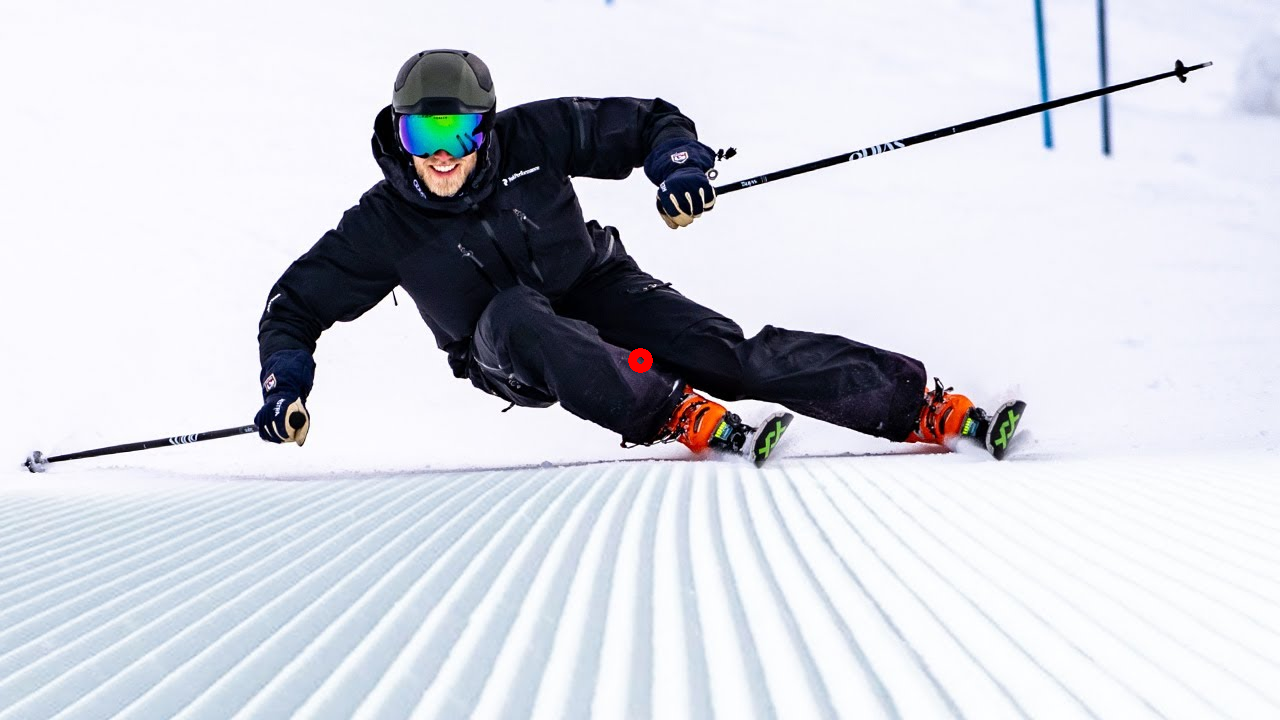

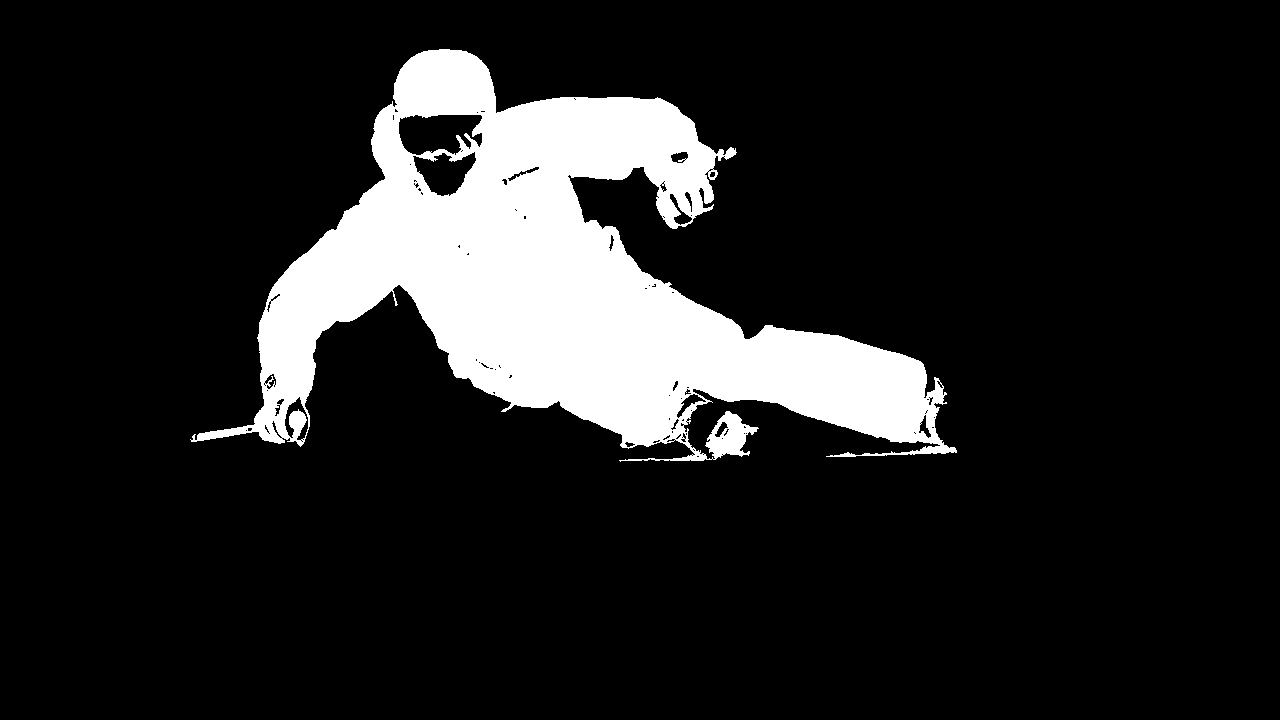

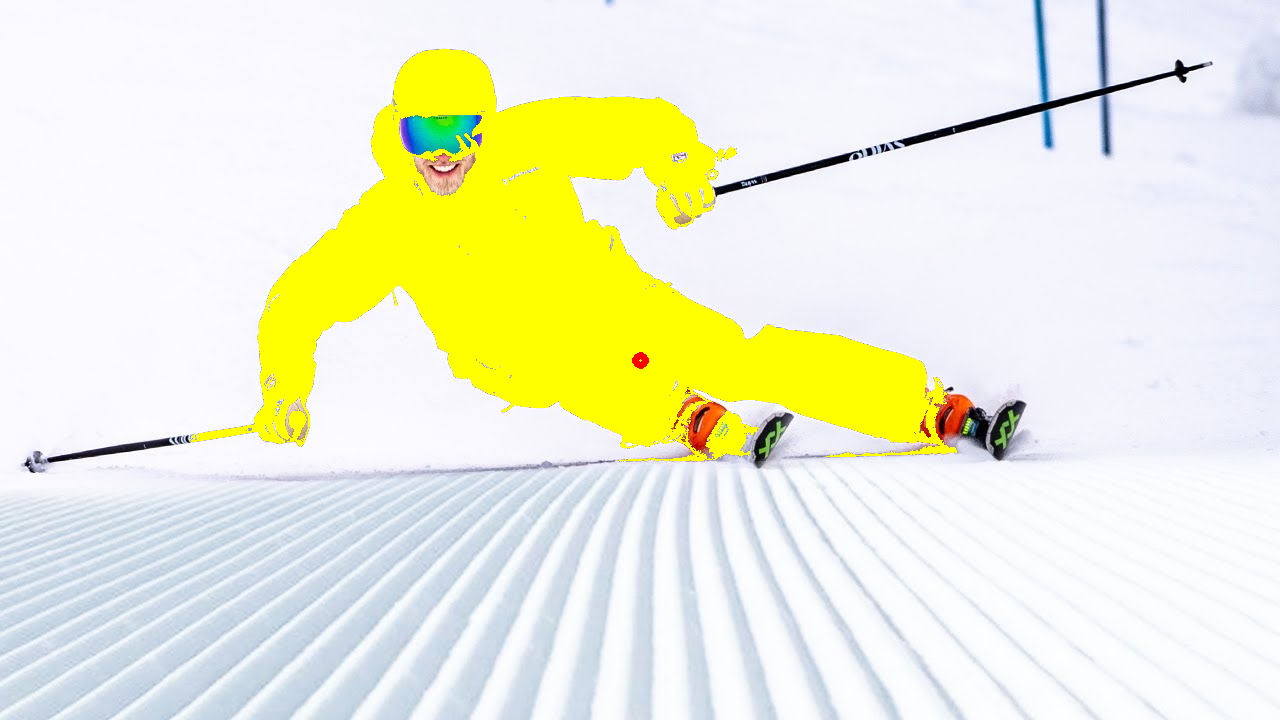

In [ ]:
img_path = os.path.join(dir_image, 'choose/skiing.jpg')
mask1 = region_segment(img_path, 0.5, 0.5, 100)

IoU of skiing = 0.8730130290825175


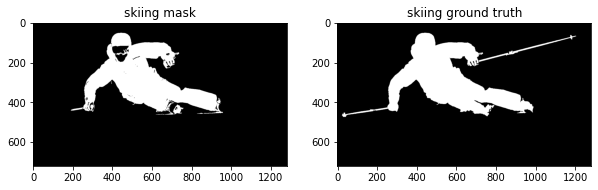

In [ ]:
gt_path = os.path.join(dir_gt, 'skiing_GT.jpg')
img_gt = cv2.imread(gt_path, 0)

# đọc ảnh màu khi có 2 seed point
# img_gt = cv2.imread(gt_path, 1) 

Show_2_Image(mask1, img_gt, 'skiing')
print("IoU of skiing = " + str(CountIOU(mask1, img_gt)))

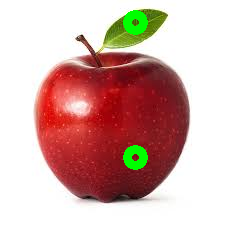

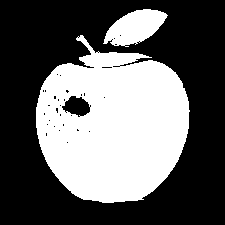

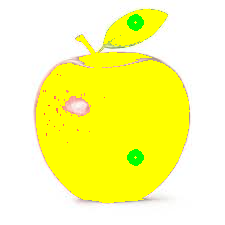

In [ ]:
img_path = os.path.join(dir_image, 'choose/apple.jpg')
mask2 = region_segment_2(img_path, 0.6, 0.7, 120, 0.6, 0.1, 100, blur=0)

IoU of apple = 0.9410977242302544


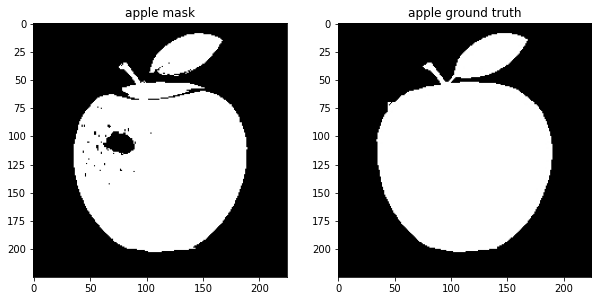

In [ ]:
gt_path = os.path.join(dir_gt, 'apple_GT.jpg')
# img_gt = cv2.imread(gt_path, 0)

# đọc ảnh màu khi có 2 seed point
img_gt = cv2.imread(gt_path, 1) 

Show_2_Image(mask2, img_gt, 'apple')
print("IoU of apple = " + str(CountIOU(mask2, img_gt)))

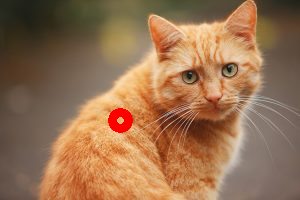

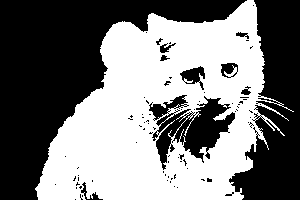

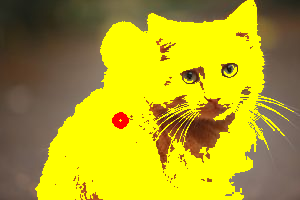

In [ ]:
img_path = os.path.join(dir_image, 'choose/cat.jpg')
mask3 = region_segment(img_path, 0.4, 0.6, 90, blur=0)

IoU of cat = 0.76024490785645


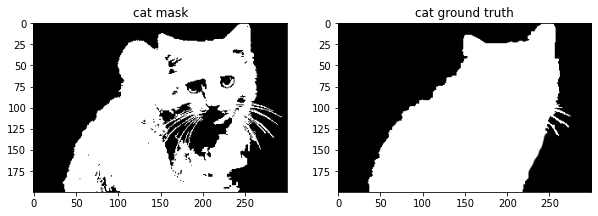

In [ ]:
gt_path = os.path.join(dir_gt, 'cat_GT.jpg')
img_gt = cv2.imread(gt_path, 0)

Show_2_Image(mask3, img_gt, 'cat')
print("IoU of cat = " + str(CountIOU(mask3, img_gt)))

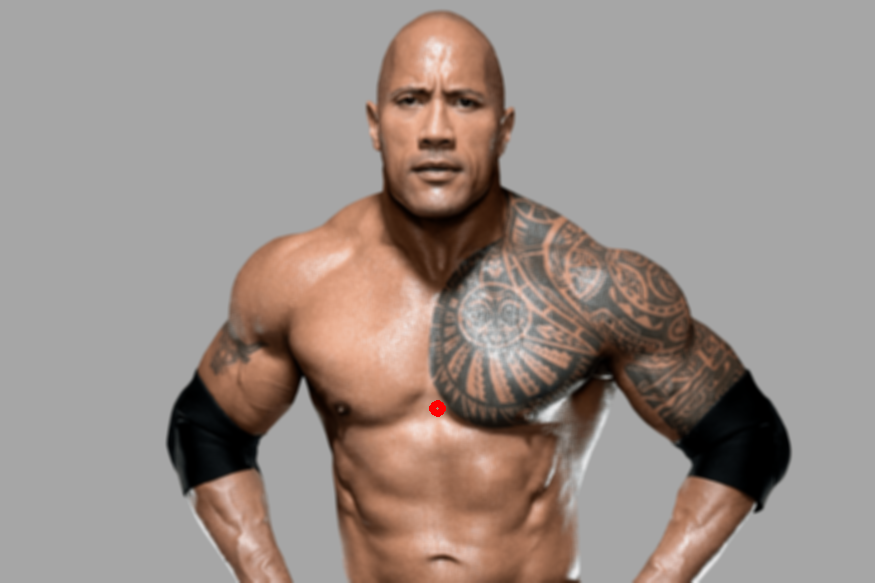

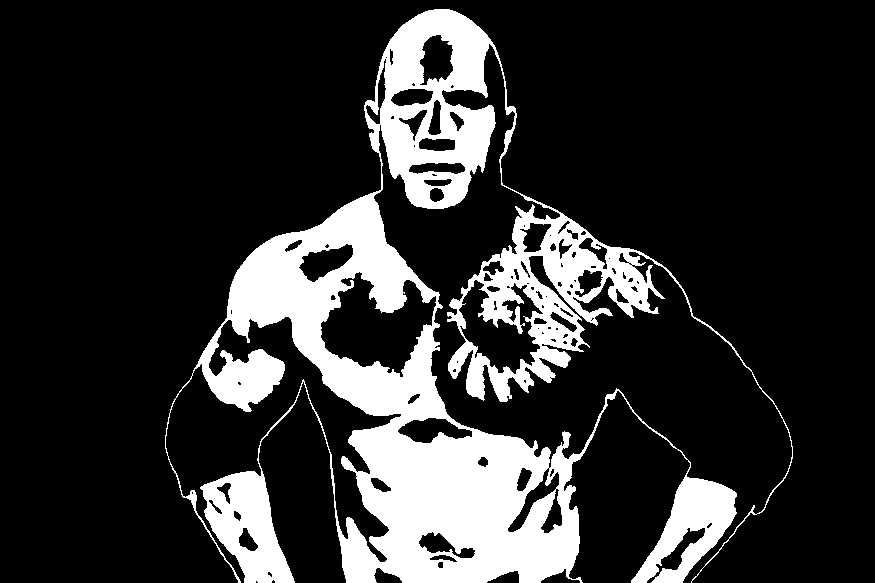

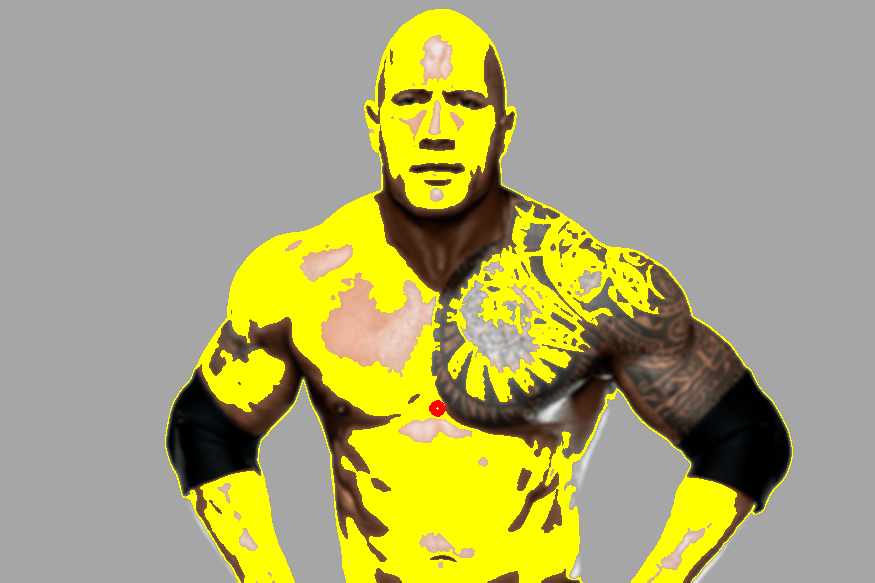

In [ ]:
img_path = os.path.join(dir_image, 'choose/therock.jpg')
mask4 = region_segment(img_path, 0.5, 0.7, 50, blur=1)

IoU of therock = 0.48905926902062097


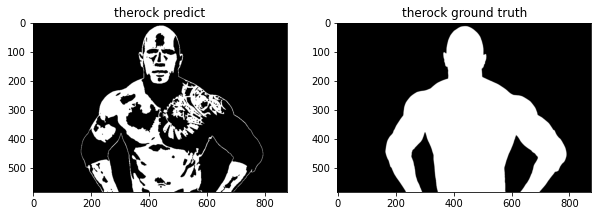

In [ ]:
gt_path = os.path.join(dir_gt, 'therock_GT.jpg')
img_gt = cv2.imread(gt_path, 0)

Show_2_Image(mask4, img_gt, 'therock')
print("IoU of therock = " + str(CountIOU(mask4, img_gt)))

# Just for fun


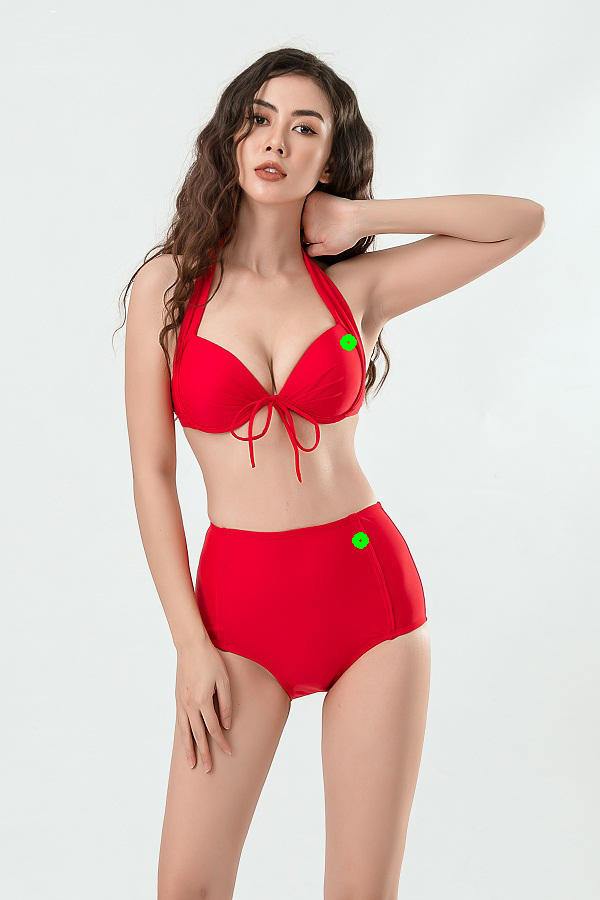

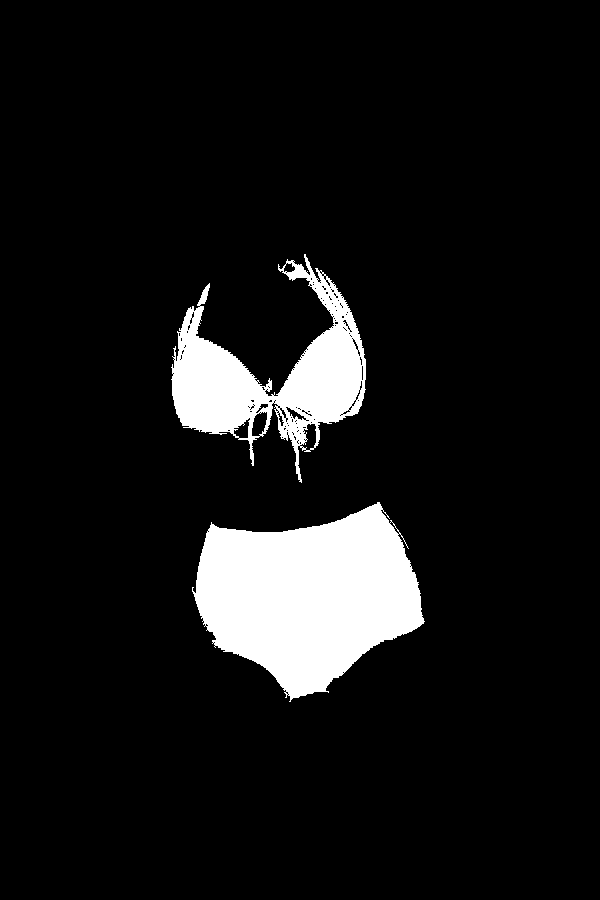

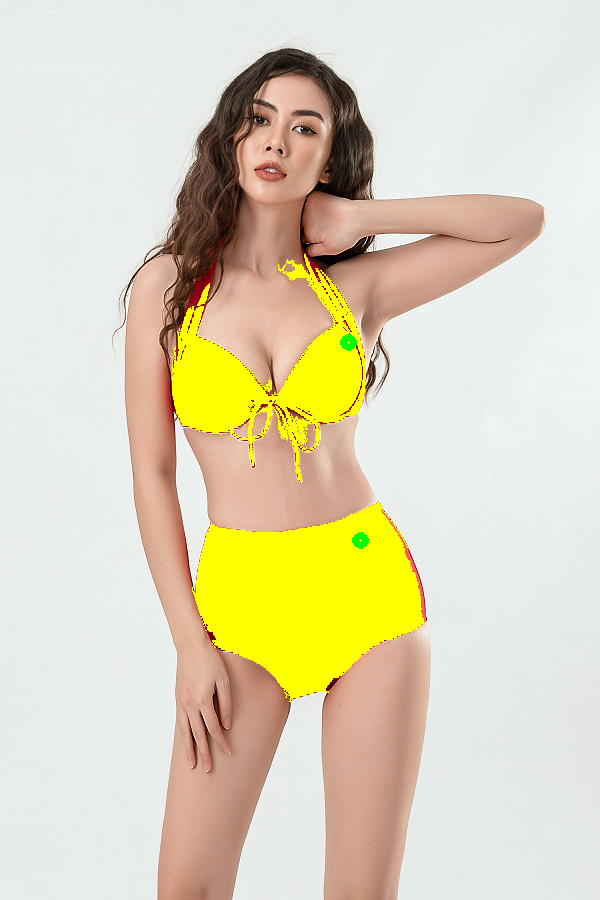

In [ ]:
img_path = os.path.join(dir_image, 'choose/bikini.jpg')
mask = region_segment_2(img_path, 0.6, 0.6, 80, 0.58, 0.38, 80)

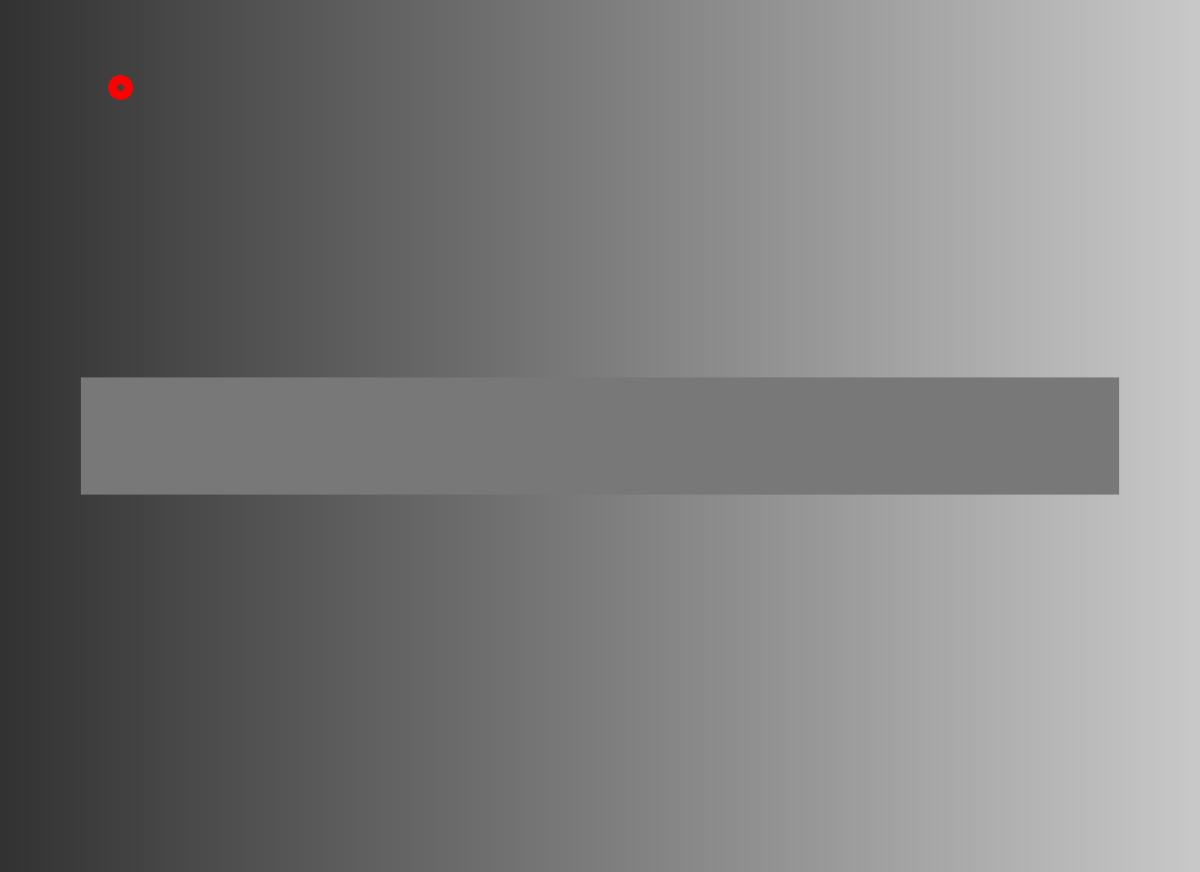

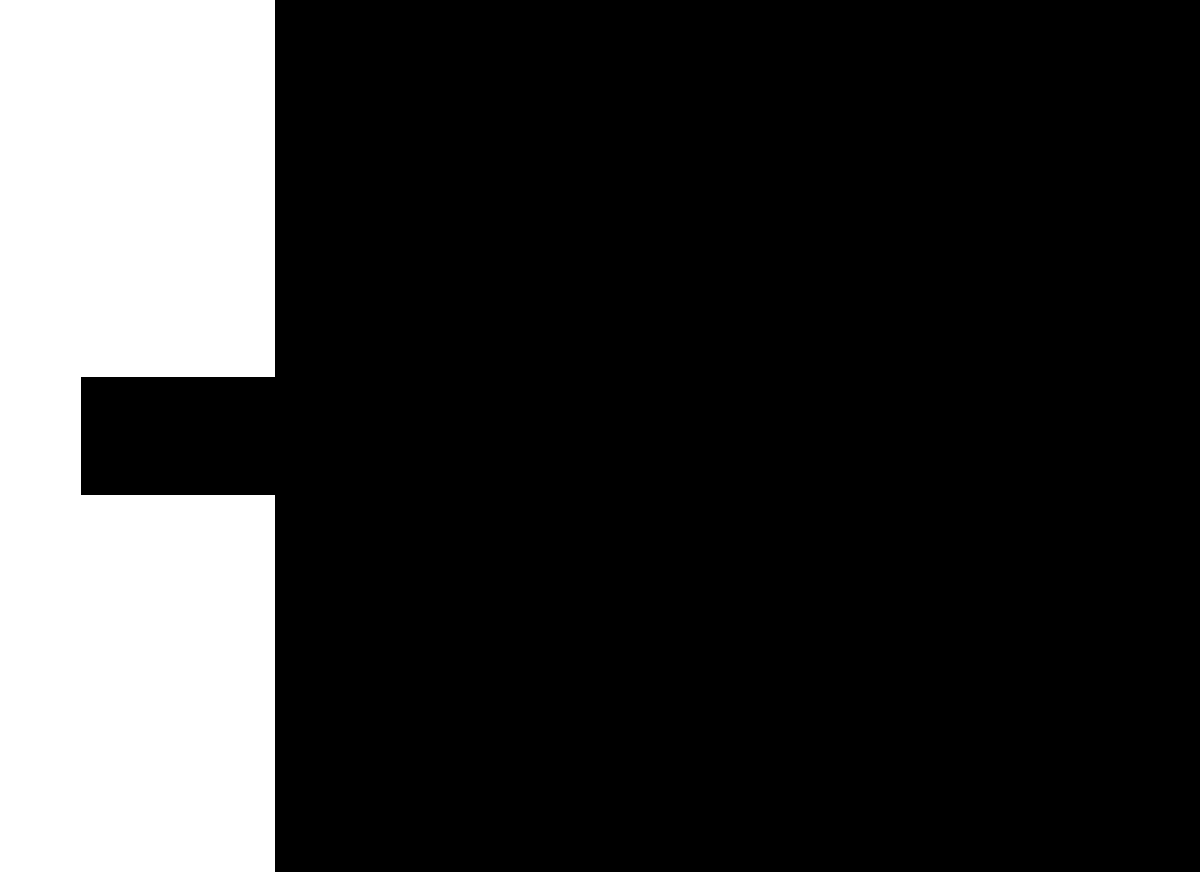

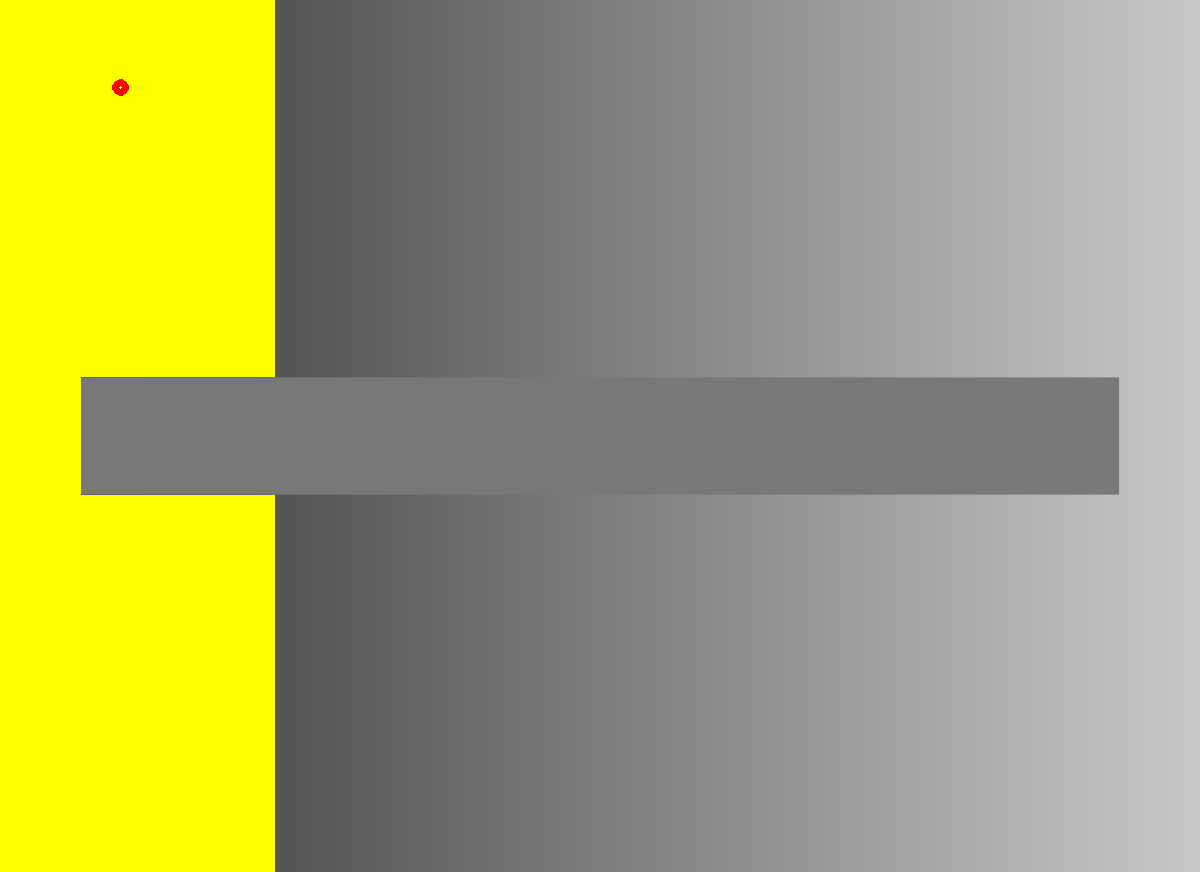

In [ ]:
img_path = os.path.join(dir_image, 'choose/test.jpg')
mask4 = region_segment(img_path, 0.1, 0.1, 20, blur=0)